In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from os import listdir
from os.path import isfile, join
from keras.callbacks import CSVLogger

In [2]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [3]:
mypath = 'D:\HomeTask\Dataset/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [34]:
for file in onlyfiles:
    df = pd.read_csv(mypath+file, sep = '\t')
    df['Date Time'] = df['<DATE>'] + df['<TIME>']
    df = df.drop(labels = 0)
    features_considered = ['<OPEN>','<HIGH>','<LOW>','<CLOSE>']
    features = df[features_considered]
    features.index = df['Date Time']
    dataset = features.values
    TRAIN_SPLIT = round(0.7*df.shape[0])
    data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
    data_std = dataset[:TRAIN_SPLIT].std(axis=0)
    dataset = (dataset-data_mean)/data_std
    past_history = 250
    future_target = 0
    STEP = 1
    x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
    x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
    
    BATCH_SIZE = 1000
    BUFFER_SIZE = 10000
    train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
    train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
    val_data_single = val_data_single.batch(BATCH_SIZE)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(250,
                                           input_shape=x_train_single.shape[-2:]))
                                           #dropout=0.5))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
    checkpoint_path = 'D:\HomeTask\LSTM_250_MAE/'+file[:-4]+'/cp-0050.ckpt'
    model.load_weights(checkpoint_path)
    x = model.predict(x_val_single)
    counter = 0
    for i in range(1, x.shape[0]):
        if (y_val_single[i] - y_val_single[i-1]) * (x[i] - x[i-1]) > 0:
            counter = counter +1
    print('On ', file, 'data accuracy = ', counter/x.shape[0])
    with open('D:\HomeTask\LSTM_250_MAE/log.csv','a') as fd:
        fd.write(file[:-4] + ';'+ str(counter/x.shape[0]) + '\n')

111/111 [==============================] - 1s 10ms/step
On  ADAUSDT_H1.csv data accuracy =  0.5918827508455468
466/466 [==============================] - 4s 8ms/step
On  ADAUSDT_M15.csv data accuracy =  0.6021325107296137
76/76 [==============================] - 1s 8ms/step
On  ANKRUSDT_H1.csv data accuracy =  0.5815485996705108
327/327 [==============================] - 3s 8ms/step
On  ANKRUSDT_M15.csv data accuracy =  0.6158489842851668
76/76 [==============================] - 1s 8ms/step
On  ATOMUSDT_H1.csv data accuracy =  0.6367380560131796
327/327 [==============================] - 3s 8ms/step
On  ATOMUSDT_M15.csv data accuracy =  0.6696368688320399
111/111 [==============================] - 1s 8ms/step
On  AVAXUSDT_H1.csv data accuracy =  0.637260428410372
466/466 [==============================] - 4s 8ms/step
On  AVAXUSDT_M15.csv data accuracy =  0.6140021459227468
76/76 [==============================] - 1s 8ms/step
On  AXSUSDT_H1.csv data accuracy =  0.6099670510708401
327/32

In [32]:
with open('D:\HomeTask\LSTM_250_MAE/log.csv','a') as fd:
    fd.write(file[:-4] + ';'+ str(counter/x.shape[0]) + '\n')

In [26]:
file[:-4]

'ADAUSDT_H1'

In [54]:
df = pd.read_csv('D:\HomeTask\LSTM_250_MAE\log.csv', sep = ';')

In [55]:
df

,tiker,accuracy
0,ADAUSDT_H1,0.591883
1,ADAUSDT_M15,0.602133
2,ANKRUSDT_H1,0.581549
3,ANKRUSDT_M15,0.615849
4,ATOMUSDT_H1,0.636738
...,...,...
61,TRXUSDT_M15,0.598471
62,VETUSDT_H1,0.651995
63,VETUSDT_M15,0.590308
64,XRPUSDT_H1,0.649577


In [50]:
mypath = "D:\HomeTask\LSTM_250_MAE/"
onlyfiles = listdir(mypath)
onlyfiles.remove('1_image')
onlyfiles.remove('log.csv')

<Figure size 9000x3000 with 0 Axes>

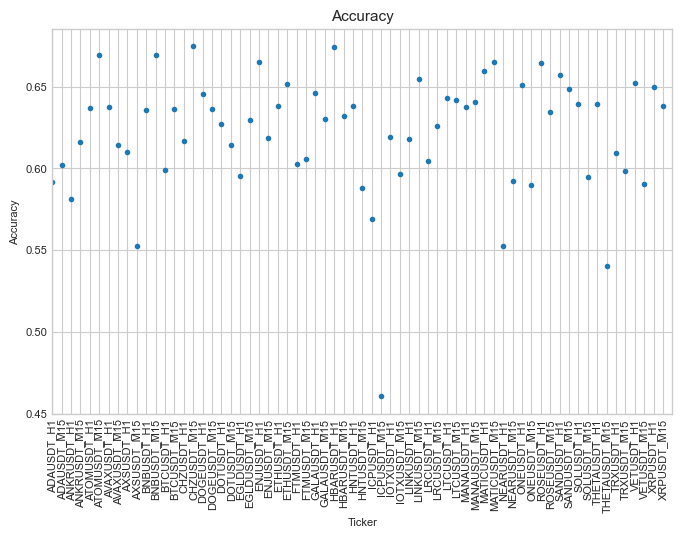

In [56]:
x = np.arange(len(onlyfiles))
fig = plt.figure(figsize=(30, 10), dpi= 300, facecolor='w', edgecolor='k')
df.plot(style='.')
plt.gca().set(xlim=(0.0, 66),xlabel='Ticker', ylabel='Accuracy')
plt.xticks(x,onlyfiles, rotation=90)
plt.title('Accuracy', fontsize=11)
plt.gca().get_legend().remove()
plt.savefig('D:\HomeTask\LSTM_250_MAE/1_image/accuracy.png', bbox_inches='tight')

In [43]:
large = 11; med = 8; small = 6
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 5),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')

C:\Users\Ivan Kushnir\AppData\Local\Temp\ipykernel_10656\3614552978.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


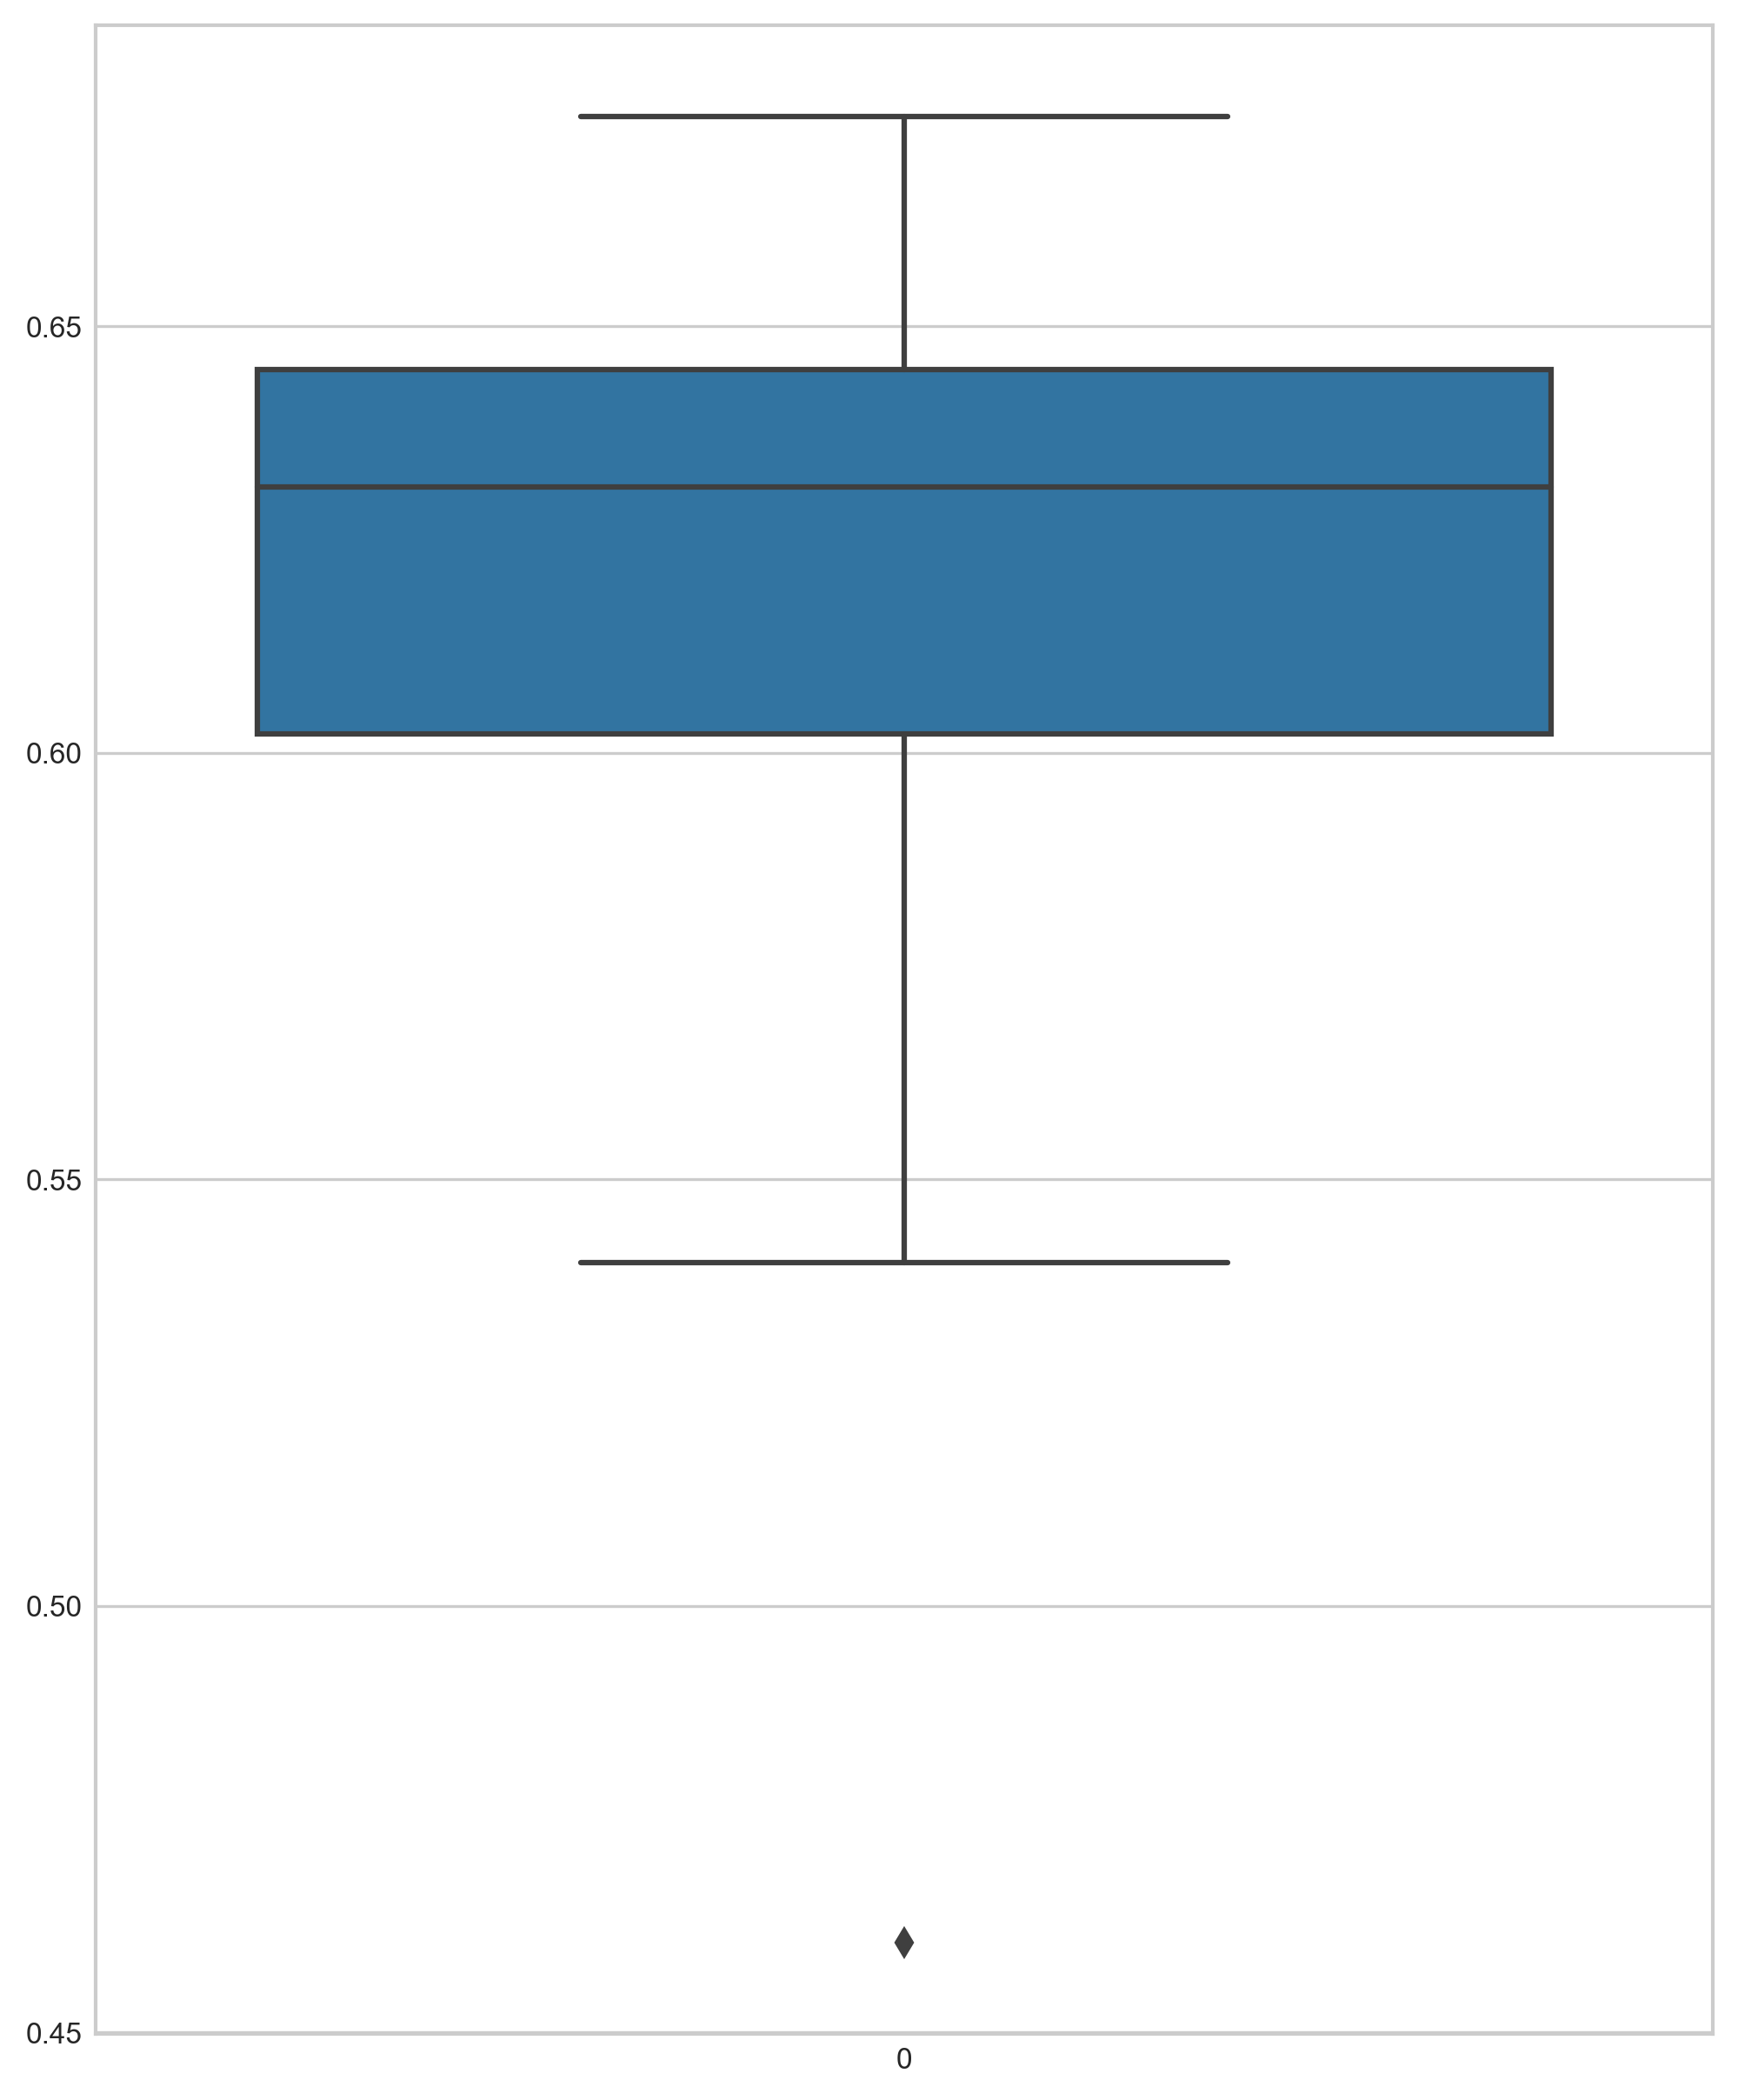

In [61]:
plt.figure(figsize=(8, 10), dpi= 300, facecolor='w', edgecolor='k')
sns.boxplot(df.accuracy)
plt.savefig('D:\HomeTask\LSTM_250_MAE/1_image/accuracy_boxplot.png', bbox_inches='tight')

In [60]:
import seaborn as sns